<a id = 'title'></a>
# Advanced Modeling

##### Author: Quinci Birker

## Introduction

In this notebook, we delve into more advanced modeling, using Random Forest Classifier (RFC) and XGBoost (XGB). The goal here is to obtain higher accuray scores as well as other metrics that will outperform our baseline model. 

### Random Forest Classifier:
- Why we chose this model:
    - RFC adds extra randomness compared to Decision Tree Model, showing more potential for higher accuracy
    - For this specific project, we have a lot of features being implemented and this model is good with working with large datasets that have multiple features.
    - Compared to more advanced models, RFC allows for more interpretation, which is important when understanding what features play a larger role in deciding whether a book is good or bad. 
    
### XGBoost:
- Why we chose this model:
    - For creating a book recommender system, XGBoost can be efficient in handling sparse data and a powerful took for this project
    - Offers regularization that helps control overfitting by using L1/L2 penalities 

### Current Project Status:
The project has progressed through several crucial stages:
- **Exploratory Data Analysis (EDA)**: Conducted a thorough examination of the dataset to understand underlying patterns and relationships.
- **Data Cleaning**: The dataset has been cleaned of inconsistencies and missing values, ensuring the quality of the data.
- **Preprocessing**: Transformed raw data into an appropriate format, making it suitable for modeling.
- **Data Engineering**: New features have been created and existing ones modified to better capture the nuances of the dataset.
- **Baseline model:** Logisitc Regression model was used for a baseline in comparing other advanced models.

References: 
- https://builtin.com/data-science/random-forest-algorithm
- https://www.simplilearn.com/what-is-xgboost-algorithm-in-machine-learning-article#:~:text=It's%20an%20open%2Dsource%20library,at%20no%20cost%20to%20accuracy!

## Table of Contents

---------------------------------------
1. [Import Dataset and Libraries](#import)
2. [Baseline Modeling - Logistic Regression](#base)
3. [Random Forest Classifier](#RFC)
4. [XGBoost](#XGB)
5. [Summary & Insights](#summary)
---------------------------------------

##  Data Dictionary 

After data cleaning and data engineering, these are the following variables that will be used the modeling process. 

| Features     | Description                                                  |
|--------------|--------------------------------------------------------------|
| pages        | The number of pages in the book.                             |
| numRatings   | The number of ratings the book has received.                 |
| bbeScore     | Score in Best Books Ever list       |
| year         | Year of publication              |
| month        | Month of publication             |
| series_bool  | Indicates whether the book is part of a series.              |
| genre_count  | The number of genres the book is categorized under.          |
| genres...    | Top 30 genres (example: Adventure)                       |

Target Variable | Description   | 
| ------------- | ------------- |  
| rating       | book rating: 1 for good rating and 0 for not a good rating. |

<a id = 'import'></a>
## Import Dataset and Libraries

In [2]:
# Import libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [3]:
# Read in the training dataset
X_train = pd.read_csv('data/X_train_df_final.csv', index_col=0)
y_train = pd.read_csv('data/y_train.csv', index_col=0)

# Read in the testing dataset
X_test = pd.read_csv('data/X_test_df_final.csv', index_col=0)
y_test = pd.read_csv('data/y_test.csv', index_col=0)

##### Sanity check training dataset

In [4]:
X_train.head()

,pages,numRatings,bbeScore,year,month,series_bool,genre_count,Adult,Adventure,Audiobook,...,Other,Paranormal,Romance,Science Fiction,Science Fiction Fantasy,Supernatural,Suspense,Thriller,Urban Fantasy,Young Adult
35783,22.0,666,89,1974,1,0,52,0,0,0,...,1,0,0,0,0,0,0,0,0,0
39773,176.0,161,83,1983,1,0,95,0,0,0,...,1,0,0,0,0,0,0,0,0,0
51074,339.0,2535,24,2014,5,1,171,0,0,0,...,1,0,1,0,0,0,0,0,0,1
7233,201.0,17367,370,2009,7,0,139,0,0,0,...,1,0,0,1,0,0,0,0,0,0
6868,224.0,94434,389,2016,11,0,125,1,0,1,...,1,0,0,0,0,0,0,0,0,0


In [5]:
X_train.shape

(33041, 38)

The X_train dataframe includes 33,041 rows and 38 columns.

In [6]:
y_train.head()

,rating
35783,1
39773,0
51074,0
7233,1
6868,0


In [7]:
y_train.shape

(33041, 1)

Scikit-Learn models generally expect the target variable to be a 1D array, so this will need to be reshaped

In [8]:
# Reshape y_train
y_train = y_train.values.ravel()
y_train.shape

(33041,)

##### Sanity check testing dataset

In [9]:
X_test.head()

,pages,numRatings,bbeScore,year,month,series_bool,genre_count,Adult,Adventure,Audiobook,...,Other,Paranormal,Romance,Science Fiction,Science Fiction Fantasy,Supernatural,Suspense,Thriller,Urban Fantasy,Young Adult
33489,346.0,1864,92,2015,9,1,147,0,0,0,...,1,0,0,0,0,0,0,0,0,0
12086,160.0,12646,194,2002,1,1,140,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8714,513.0,62049,289,2019,9,1,131,0,0,0,...,1,0,0,0,0,0,0,0,0,0
36527,432.0,3347,88,2012,3,0,127,0,0,0,...,1,0,0,0,0,0,0,0,0,0
12745,345.0,115,190,2014,6,1,65,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [10]:
X_test.shape

(8261, 38)

The X_test dataframe includes 8,261 rows and 38 columns.

In [11]:
y_test.head()

,rating
33489,1
12086,0
8714,1
36527,1
12745,0


In [12]:
y_test.shape

(8261, 1)

In [13]:
# Reshape the y_test
y_test = y_test.values.ravel()
y_test.shape

(8261,)

Notes: after reviewing each dataframe, everything looks good and is ready for the modeling stage.

<a id = 'base'></a>
## Baseline Modeling

The baseline will be a logistic regression model. This will be used for future testing in how other models perform.

The model will predict whether a book has a good rating (1) or a bad rating (0).<a id = 'base_model'></a>

<a id = 'scale'></a>
##### Scale the data

Scaling ensures that each feature equally contributes to the modeling process, enhancing model performance. Consider the difference between the 'pages' and 'month' columns in this dataset: 'pages' varies across a range of over 3,000, where 'month' only goes up to 12. Without scaling, the model could disproportionately emphasize 'pages' due to its broader range.

The scaler of choice is the Standard Scaler, where the scaled distribution is centered at 0 and the variance will be based on the number of standard deviation away from the mean (the center). The reason for using this scaler is that in many cases, the Standard Scaler is often preferred and shows good performance.  

Since the majority of columns are binary, only the non-binary columns will be scaled. 
First, seperate the binary from non-binary columns and then apply the standard scaler to only the non-binary columns. 

**Reference:** BrainStation's Scaling kickoff notebook

In [14]:
# Identify non-binary columns
# non_binary_cols = [col for col in X_train_df_final.columns if len(X_train_df_final[col].unique()) > 2]
non_binary_cols = ['pages', 'numRatings', 'bbeScore', 'year', 'month']

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale only non-binary columns
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[non_binary_cols] = scaler.fit_transform(X_train[non_binary_cols])
X_test_scaled[non_binary_cols] = scaler.transform(X_test[non_binary_cols])

In [15]:
# Instantiate and fit logisitc regression
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

# Train and test scores
print(f'Train score: {logreg.score(X_train_scaled, y_train)}')
print(f'Test score: {logreg.score(X_test_scaled, y_test)}')

Train score: 0.6415665385430223
Test score: 0.517491829076383


/Users/quincibirker/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
# Make predictions on the test data
y_pred_logreg = logreg.predict(X_test_scaled)

The baseline logisitc regression has a train score of 64 percent and a test score of 52 percent. There seems to be overfitting and the overall test accuracy is not strong. This will still be used as a baseline and hopefully testing out different models will improve the prediction accuracy for the test set.

In [17]:
# Extract the coefficients
coefficients = logreg.coef_[0]

# Calculate the odds ratios
odds_ratio = np.exp(coefficients)

# Get the feature names
feature_names = X_train.columns

# Create a DataFrame with feature names and their corresponding coefficients and odds ratios
feature_coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Odds_ratio': odds_ratio
})

# Sort the coefficients from highest to lowest
feature_coefficients = feature_coefficients.sort_values(by='Coefficient', ascending=False)

# Display 
feature_coefficients

,Feature,Coefficient,Odds_ratio
5,series_bool,0.833176,2.300613
0,pages,0.489714,1.631849
11,Childrens,0.449391,1.567357
12,Classics,0.398184,1.489119
14,Contemporary Romance,0.301780,1.352264
34,Suspense,0.192391,1.212144
28,Other,0.185002,1.203220
1,numRatings,0.137388,1.147273
3,year,0.103011,1.108504
26,Nonfiction,0.057649,1.059343


Highest odds ratio:
- The series columns has the highest coefficient of around 0.83. If the book is in a series, it has 2.3 times better odds to have a good review than if it's not in a series.
- From the genres columns, Childrens, Classocs and Contemporary Romance have the highest odds ratios.

Lowest odds ratio:
- From the genres columns, Chick Lit has the highest negative correlation of around -0.71 and Mystery being second with around -0.62

Notes:
- In future, the genres could be filtered through a bit more. For example, in the top 30 genres, there is Historical, Historical Fiction, and History. These could be put into a single category to allow for other genres.

##### Classification Report & Confusion Matrix

What are we looking at here?
- Recall: This metric assesses the model's ability to correctly identify all instances of the positive class.
- Precision: This reflects the likelihood that a data point identified by the model as positive actually belongs to the positive class.
- F1-score: a measure that combines recall and precision to provide a single score for the model's overall performance.

**Reference:** BrainStation's Precision and Recall notebook.

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.46      0.03      0.05      3968
           1       0.52      0.97      0.68      4293

    accuracy                           0.52      8261
   macro avg       0.49      0.50      0.36      8261
weighted avg       0.49      0.52      0.37      8261



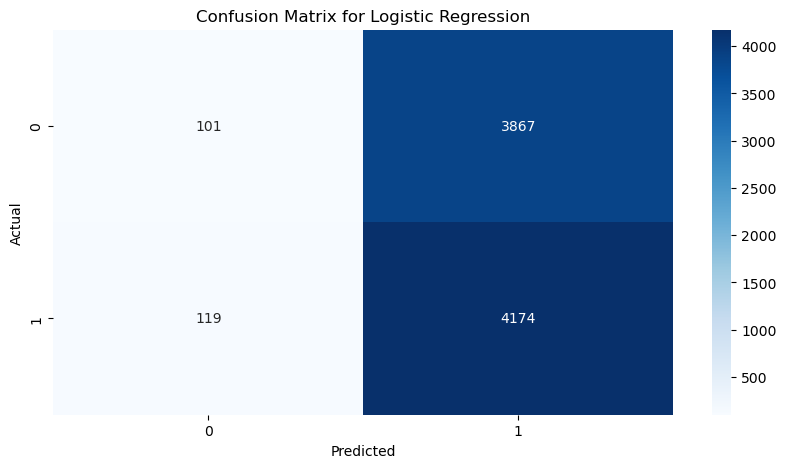

In [18]:
# Classification report
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_logreg))

# Generate the confusion matrix
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)

# Confusion matrix heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix_logreg, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Reference:** code used from BrainStation's kickoff lesson.

##### Model Summary

|    | Model Type          | Train Accuracy | Test Accuracy | Precision | Recall | Notes                  |
|----|---------------------|----------------|---------------|-----------|--------|------------------------|
| 1. | Logistic Regression | 62%            | 52%           | 52%       | 97%    | Baseline/No parameters |

<a id = 'RFC'></a>
## Random Forest Classifier

##### Random Search

To efficiently tune hyperparameters, we will start with a random search to quickly explore a wide range of options. Then, using the insights gained, we will conduct a more targeted grid search in a narrowed range. This approach combines the speed of random search with the thoroughness of grid search for better results.

In [49]:
# Initialize the classifier
rf = RandomForestClassifier(random_state=55)

# Define the parameter space
param_distributions = {
    'max_depth':list(np.arange(10, 100, step=10)) + [None],
    'n_estimators':np.arange(10, 500, step=50),
    'max_features':randint(1,7),
    'criterion':['gini','entropy'],
    'min_samples_leaf':randint(1,4),
    'min_samples_split':np.arange(2, 10, step=2)
}

# Set up the random search with cross-validation
random_search = RandomizedSearchCV(rf, param_distributions=param_distributions, 
                                   n_iter=50, cv=5, verbose=2, random_state=55)

# Fit the random search model
random_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", random_search.best_params_)

# Use the best estimator to make predictions
best_rf = random_search.best_estimator_
y_pred_RFC = best_rf.predict(X_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END criterion=entropy, max_depth=80, max_features=1, min_samples_leaf=2, min_samples_split=4, n_estimators=260; total time=   2.3s
[CV] END criterion=entropy, max_depth=80, max_features=1, min_samples_leaf=2, min_samples_split=4, n_estimators=260; total time=   2.3s
[CV] END criterion=entropy, max_depth=80, max_features=1, min_samples_leaf=2, min_samples_split=4, n_estimators=260; total time=   2.3s
[CV] END criterion=entropy, max_depth=80, max_features=1, min_samples_leaf=2, min_samples_split=4, n_estimators=260; total time=   2.3s
[CV] END criterion=entropy, max_depth=80, max_features=1, min_samples_leaf=2, min_samples_split=4, n_estimators=260; total time=   2.4s
[CV] END criterion=entropy, max_depth=60, max_features=4, min_samples_leaf=2, min_samples_split=6, n_estimators=10; total time=   0.2s
[CV] END criterion=entropy, max_depth=60, max_features=4, min_samples_leaf=2, min_samples_split=6, n_estimators=10; total t

[CV] END criterion=gini, max_depth=40, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=60; total time=   0.9s
[CV] END criterion=gini, max_depth=40, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=60; total time=   0.9s
[CV] END criterion=gini, max_depth=40, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=60; total time=   0.9s
[CV] END criterion=gini, max_depth=40, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=60; total time=   0.9s
[CV] END criterion=gini, max_depth=30, max_features=1, min_samples_leaf=2, min_samples_split=2, n_estimators=160; total time=   1.3s
[CV] END criterion=gini, max_depth=30, max_features=1, min_samples_leaf=2, min_samples_split=2, n_estimators=160; total time=   1.3s
[CV] END criterion=gini, max_depth=30, max_features=1, min_samples_leaf=2, min_samples_split=2, n_estimators=160; total time=   1.3s
[CV] END criterion=gini, max_depth=30, max_features=1, min_samples_leaf=2

[CV] END criterion=entropy, max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END criterion=entropy, max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END criterion=entropy, max_depth=80, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=310; total time=   7.3s
[CV] END criterion=entropy, max_depth=80, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=310; total time=   7.3s
[CV] END criterion=entropy, max_depth=80, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=310; total time=   7.3s
[CV] END criterion=entropy, max_depth=80, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=310; total time=   7.3s
[CV] END criterion=entropy, max_depth=80, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=310; total time=   7.2s
[CV] END criterion=entropy, max_depth=50, max_feat

[CV] END criterion=gini, max_depth=50, max_features=6, min_samples_leaf=3, min_samples_split=4, n_estimators=60; total time=   1.2s
[CV] END criterion=gini, max_depth=50, max_features=6, min_samples_leaf=3, min_samples_split=4, n_estimators=60; total time=   1.2s
[CV] END criterion=gini, max_depth=50, max_features=6, min_samples_leaf=3, min_samples_split=4, n_estimators=60; total time=   1.2s
[CV] END criterion=gini, max_depth=50, max_features=6, min_samples_leaf=3, min_samples_split=4, n_estimators=60; total time=   1.2s
[CV] END criterion=gini, max_depth=50, max_features=6, min_samples_leaf=3, min_samples_split=4, n_estimators=60; total time=   1.2s
[CV] END criterion=entropy, max_depth=30, max_features=3, min_samples_leaf=1, min_samples_split=6, n_estimators=160; total time=   2.7s
[CV] END criterion=entropy, max_depth=30, max_features=3, min_samples_leaf=1, min_samples_split=6, n_estimators=160; total time=   2.7s
[CV] END criterion=entropy, max_depth=30, max_features=3, min_sample

[CV] END criterion=entropy, max_depth=80, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=310; total time=   7.3s
[CV] END criterion=entropy, max_depth=80, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=310; total time=   7.3s
[CV] END criterion=entropy, max_depth=80, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=310; total time=   7.3s
Best parameters found:  {'criterion': 'entropy', 'max_depth': 80, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 310}


Best parameters found:  {'criterion': 'entropy', 'max_depth': 80, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 310}

##### Check model accuracy with the best parameters

In [53]:
accuracy = best_rf.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5236654158092241


##### Perform a grid search

In [28]:
# Initialize the classifier
rf = RandomForestClassifier(random_state=55)

# Define the parameter grid
param_grid = {
    'criterion': ['entropy'],  # No change needed as it's categorical
    'max_depth': [70, 80, 90],
    'max_features': [4, 5, 6],
    'min_samples_split': [3, 4, 5],
    'n_estimators': [290, 310, 330]
}

# Set up the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best score is: "+str(grid_search.best_score_))

# Use the best estimator to make predictions
best_rf = grid_search.best_estimator_
y_pred_RFC = best_rf.predict(X_test)

Best parameters found:  {'criterion': 'entropy', 'max_depth': 70, 'max_features': 5, 'min_samples_split': 4, 'n_estimators': 290}
Best score is: 0.7135979689813252


Best parameters found:  
- 'criterion': 'entropy'
- 'max_depth': 70
- 'max_features': 5
- 'min_samples_split': 4
- 'n_estimators': 290

##### Random Forest Model with new parameters

In [19]:
params = {
    'criterion': 'entropy',
    'max_depth': 70,  
    'max_features': 5,  
    'min_samples_split': 4,  
    'n_estimators': 290  
}

# Initialize the RandomForestClassifier with these parameters
rf_model = RandomForestClassifier(**params, random_state=55)

# Fit the model to your training data (assuming you have X_train and y_train)
rf_model.fit(X_train, y_train)

# Use rf_model to make predictions 
y_pred_RFC = rf_model.predict(X_test)

print(f'Train score: {rf_model.score(X_train, y_train)}')
print(f'Test score: {rf_model.score(X_test, y_test)}')

Train score: 0.9991223025937471
Test score: 0.5235443650889723


##### Classification Report & Confusion Matrix

              precision    recall  f1-score   support

           0       0.71      0.01      0.03      3968
           1       0.52      0.99      0.68      4293

    accuracy                           0.52      8261
   macro avg       0.62      0.50      0.36      8261
weighted avg       0.61      0.52      0.37      8261



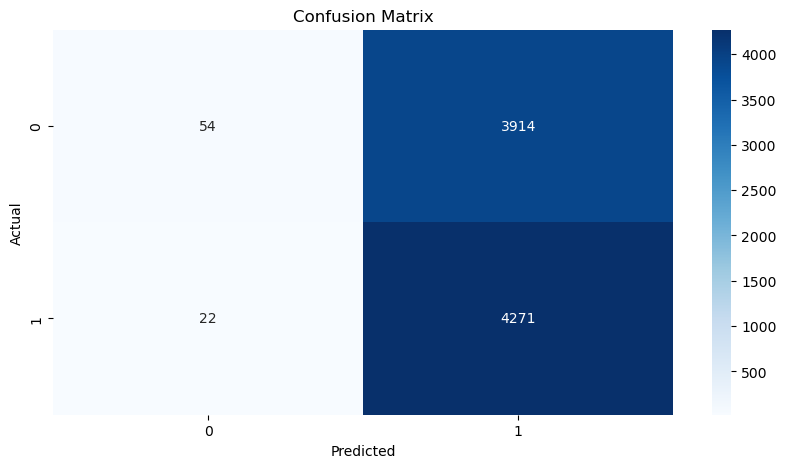

In [18]:
# Classification report
print(classification_report(y_test, y_pred_RFC))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_RFC)

# Confusion matrix heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues') 
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Reference:** code used from BrainStation's kickoff lesson.

##### Feature importance

In [20]:
feature_importances = rf_model.feature_importances_

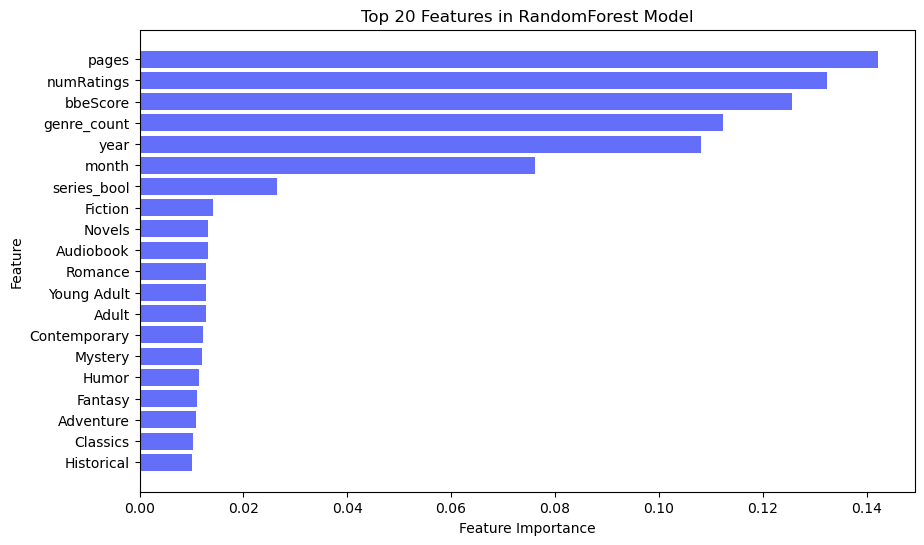

In [21]:
feature_names = X_train.columns if hasattr(X_train, 'columns') else np.arange(X_train.shape[1])

# Sorting the features with their importance
sorted_idx = np.argsort(feature_importances)[-20:]  # Get indices of top 20 features
sorted_importances = feature_importances[sorted_idx]
sorted_features = [feature_names[i] for i in sorted_idx]

# Creating the plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='#636EF9')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 20 Features in RandomForest Model")
plt.show()

##### Model Summary

|    | Model Type               | Train Accuracy | Test Accuracy | Precision | Recall | Notes                  |
|----|--------------------------|----------------|---------------|-----------|--------|------------------------|
| 1. | Logistic Regression      | 62%            | 52%           | 52%       | 97%    | Baseline/No parameters |
| 2. | Random Forest Classifier | 100%           | 52%           | 52%       | 100%   | With grid search       |

<a id = 'XGB'></a>
## XGBoost Model

In [10]:
# Fit the model on training data
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [15]:
# Fit the model on training data
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Make predictions for the training data
y_pred_train = xgb_model.predict(X_train)
predictions_train = [round(value) for value in y_pred_train]

# Make predictions for the test data
y_pred_test = xgb_model.predict(X_test)
predictions_test = [round(value) for value in y_pred_test]

# Evaluate predictions
train_accuracy = accuracy_score(y_train, predictions_train)
test_accuracy = accuracy_score(y_test, predictions_test)

print("Train Accuracy: %.2f%%" % (train_accuracy * 100.0))
print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

Train Accuracy: 80.83%
Test Accuracy: 53.12%


##### Classification Report & Confusion Matrix

              precision    recall  f1-score   support

           0       0.67      0.05      0.09      3968
           1       0.53      0.98      0.68      4293

    accuracy                           0.53      8261
   macro avg       0.60      0.51      0.39      8261
weighted avg       0.60      0.53      0.40      8261



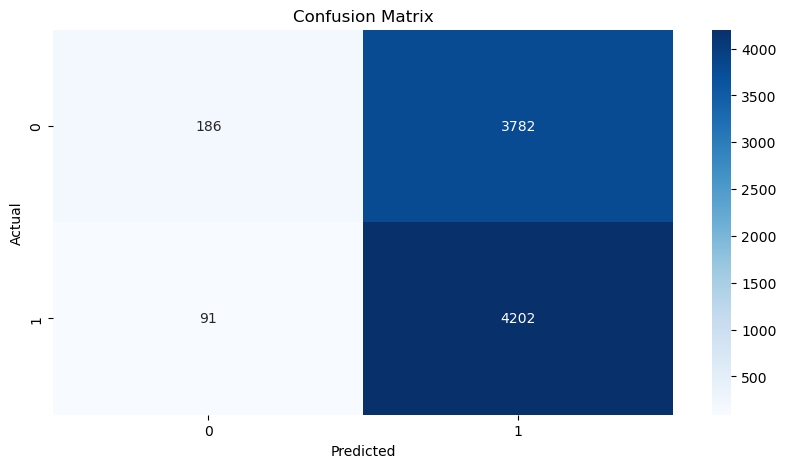

In [16]:
# Classification report
print(classification_report(y_test, predictions_test))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_test)

# Confusion matrix heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues') 
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Reference:** code used from BrainStation's kickoff lesson.

##### Model Summary

|     | Model Type               | Train Accuracy | Test Accuracy | Precision | Recall | Notes                    |
|-----|--------------------------|----------------|---------------|-----------|--------|--------------------------|
| 1.  | Logistic Regression      | 62%            | 52%           | 52%       | 97%    | Baseline/No parameters   |
| 2.  | Random Forest Classifier | 100%           | 52%           | 52%       | 100%   | Grid search performed    |
| 3.  | XGBoost                  | 81%            | 53%           | 53%       | 98%    | No grid search performed |

<a id = 'summary'></a>
## Summary & Insights


In this notebook, we performed three different models: Logisitic Regression, Random Forest Classifier, and XGBoost. All three models seem to have a very low accuracy scores. Looking at the Classification Report of all the models, we can see that the model performs well at predicting Class 1. On the otherhand, the model has very low recall scores for Class 0, meaning that it does very porely at predicting Class 0 when it is indeed Class 0.  

The next steps are to revist data preprocessing and feature engineering. 

Potential feature engineering steps:
- Use text vecorization on the Title and Descriptions
- Revist the genres column to better decide on how many genres should be kept. Potentially looking into different ways on choosing what the popular genres are. 
- Looking at the awards column

[Back to the top](#title)